In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install omegaconf==2.1.1
!pip install einops==0.3.0
!pip install transformers==4.19.2
!pip install clip
!pip install taming-transformers-rom1504
!pip install kornia==0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 74 kB 3.5 MB/s 
     |████████████████████████████████| 112 kB 35.7 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141231 sha256=206903ab84372c8552d4de1e74c35eeafe1cc1b3b6e5a34511943dec283c6073
  Stored in directory: /root/.cache/pip/wheels/c8/d0/ab/d43c02eaddc5b9004db86950802442ad9a26f279c619e28da0
Successfully built antlr4-python3-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 15.4 MB/s 
     |████████████████████████████████| 182 kB 95.4 MB/s 
     |████████████████████████████████| 6.6 MB 79.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=7005 sha256=bb5713de2ae265036166e9305f68a33ab4ceea685a63f9170e6b371af32e4950
  Stored in directory: /root/.cache/pip/wheels/6d/17/18/6193c6b02f9e35e3b3f0721a349b9f9f74bac11feb0f86fdd1
Successfully built clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 257 kB/s 
     |████████████████████████████████| 798 kB 32.0 MB/s 
     |████████████████████████████████| 

In [3]:
!git clone https://github.com/CompVis/stable-diffusion.git

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 42.65 MiB | 27.35 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [4]:
%cd stable-diffusion

/content/stable-diffusion


In [5]:
import argparse, os, sys, glob
import PIL
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
from torch import autocast
from contextlib import nullcontext
import time
#from pytorch_lightning import seed_everything
import matplotlib.pyplot as plt

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

In [6]:
# Retrieved and modified from https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/ldm/models/diffusion/ddim.py

#
# These functions are from the stable diffusion repository
# For p_sample_ddim, we only removed the @torch.no_grad() decorator to allow differentiation
# For decode, we removed the decorator, and added a list to return all the samples computed in the backward direction at
# the different times t, while the implementation from the repository returns only the last one
#

from ldm.modules.diffusionmodules.util import make_ddim_sampling_parameters, make_ddim_timesteps, noise_like

#@torch.no_grad()
def p_sample_ddim(self, x, c, t, index, repeat_noise=False, use_original_steps=False, quantize_denoised=False,
                  temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                  unconditional_guidance_scale=1., unconditional_conditioning=None):
    b, *_, device = *x.shape, x.device

    if unconditional_conditioning is None or unconditional_guidance_scale == 1.:
        e_t = self.model.apply_model(x, t, c)
    else:
        x_in = torch.cat([x] * 2)
        t_in = torch.cat([t] * 2)
        c_in = torch.cat([unconditional_conditioning, c])
        e_t_uncond, e_t = self.model.apply_model(x_in, t_in, c_in).chunk(2)
        e_t = e_t_uncond + unconditional_guidance_scale * (e_t - e_t_uncond)

    if score_corrector is not None:
        assert self.model.parameterization == "eps"
        e_t = score_corrector.modify_score(self.model, e_t, x, t, c, **corrector_kwargs)

    alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
    alphas_prev = self.model.alphas_cumprod_prev if use_original_steps else self.ddim_alphas_prev
    sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
    sigmas = self.model.ddim_sigmas_for_original_num_steps if use_original_steps else self.ddim_sigmas
    # select parameters corresponding to the currently considered timestep
    a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
    a_prev = torch.full((b, 1, 1, 1), alphas_prev[index], device=device)
    sigma_t = torch.full((b, 1, 1, 1), sigmas[index], device=device)
    sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index],device=device)

    # current prediction for x_0
    pred_x0 = (x - sqrt_one_minus_at * e_t) / a_t.sqrt()
    if quantize_denoised:
        pred_x0, _, *_ = self.model.first_stage_model.quantize(pred_x0)
    # direction pointing to x_t
    dir_xt = (1. - a_prev - sigma_t**2).sqrt() * e_t
    noise = sigma_t * noise_like(x.shape, device, repeat_noise) * temperature
    if noise_dropout > 0.:
        noise = torch.nn.functional.dropout(noise, p=noise_dropout)

    x_prev = a_prev.sqrt() * pred_x0 + dir_xt + noise
    return x_prev, pred_x0

#@torch.no_grad()
def decode(self, x_latent, cond, t_start, unconditional_guidance_scale=1.0, unconditional_conditioning=None,
           use_original_steps=False):

    timesteps = np.arange(self.ddpm_num_timesteps) if use_original_steps else self.ddim_timesteps
    timesteps = timesteps[:t_start]

    time_range = np.flip(timesteps)
    total_steps = timesteps.shape[0]

    iterator = time_range
    x_dec = x_latent
    images = [x_dec]
    for i, step in enumerate(iterator):
        index = total_steps - i - 1        
        assert timesteps[index] == step
        ts = torch.full((x_latent.shape[0],), step, device=x_latent.device, dtype=torch.long)
        x_dec, _ = p_sample_ddim(self, x_dec, cond, ts, index=index, use_original_steps=use_original_steps,
                                 unconditional_guidance_scale=unconditional_guidance_scale,
                                 unconditional_conditioning=unconditional_conditioning)
        images.append(x_dec)
    return images

In [7]:
# Helpers retrieved from https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/scripts/img2img.py

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    w = w // 2
    h = h // 2
    print(f"loaded input image of size ({w}, {h}) from {path}")
    #w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    w, h = map(lambda x: x - x % 64, (w, h))  # resize to integer multiple of 64
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

In [8]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Code retrieved from https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/scripts/img2img.py

# Parameters
class Args(): pass
opt = Args()
opt.prompt = "a room"
opt.init_img = "../10219412_1.jpeg"
opt.outdir = "outputs/img2img-samples"
opt.skip_grid = False
opt.skip_save = False
opt.ddim_steps = 15 # Number of ddim sampling steps
opt.plms = False # Use plms sampling
opt.fixed_code = False # If enabled, uses the same starting code across all samples 
opt.ddim_eta = 0.0 # eta=0.0 corresponds to deterministic sampling
opt.n_iter = 1 # Sample this often
opt.C = 4 # Latent channels
opt.f = 8 # Downsampling factor, most often 8 or 16
opt.n_samples = 1 # How many samples to produce for each given prompt. A.k.a batch size
opt.n_rows = 0  # Rows in the grid (default: n_samples)
opt.scale = 5.0 # Unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty))
opt.strength = 1.0 # Strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
#opt.from_file = None str # If specified, load prompts from this file
opt.config = "configs/stable-diffusion/v1-inference.yaml" # Path to config which constructs model
opt.ckpt = "/content/gdrive/MyDrive/image_captioning/sd-v1-4.ckpt" # "models/ldm/stable-diffusion-v1/model.ckpt" # path to checkpoint of model
opt.seed = 42 # The seed (for reproducible sampling)
opt.precision = "autocast" # choices=["full", "autocast"], Evaluate at this precision

#seed_everything(opt.seed)
config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")

Loading model from /content/gdrive/MyDrive/image_captioning/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v1.10.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Downloading: "https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth" to /root/.cache/torch/hub/checkpoints/checkpoint_liberty_with_aug.pth


  0%|          | 0.00/5.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/939k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Downloading:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.layer_norm2.bias', 'vision_model.encoder.layers.21.mlp.fc2.bias', 'vision_model.encoder.layers.16.self_attn.out_proj.bias', 'vision_model.encoder.layers.4.layer_norm1.weight', 'vision_model.encoder.layers.4.layer_norm2.weight', 'vision_model.encoder.layers.18.self_attn.k_proj.weight', 'vision_model.encoder.layers.18.self_attn.out_proj.bias', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.12.self_attn.out_proj.bias', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.11.mlp.fc2.bias', 'vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.layer_norm1.weight', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.23.self_attn.q_proj.bias', 'vision_model.encoder.layers.16.layer_norm2.weight', 'vision_model.encoder.layers.19

In [ ]:
# Code adapted from https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/scripts/img2img.py

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

if opt.plms:
    raise NotImplementedError("PLMS sampler not (yet) supported")
    sampler = PLMSSampler(model)
else:
    sampler = DDIMSampler(model)

os.makedirs(opt.outdir, exist_ok=True)
outpath = opt.outdir
batch_size = opt.n_samples
n_rows = opt.n_rows if opt.n_rows > 0 else batch_size
prompt = opt.prompt
assert prompt is not None
data = [batch_size * [prompt]]
sample_path = os.path.join(outpath, "samples")
os.makedirs(sample_path, exist_ok=True)
base_count = len(os.listdir(sample_path))
grid_count = len(os.listdir(outpath)) - 1
#assert os.path.isfile(opt.init_img)
#init_image = load_img(opt.init_img).to(device)
#init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)

# Quick test: creating a red square. A better way to do that would be to use an image of a red square
init_image = torch.zeros((1, 3, 256, 320)).cuda()
init_image[:, 0, 156//2:356//2, 252//2:452//2] = 1

init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))
sampler.make_schedule(ddim_num_steps=opt.ddim_steps, ddim_eta=opt.ddim_eta, verbose=False)
assert 0. <= opt.strength <= 1., 'can only work with strength in [0.0, 1.0]'
t_enc = int(opt.strength * opt.ddim_steps)
#print(f"target t_enc is {t_enc} steps")
precision_scope = autocast if opt.precision == "autocast" else nullcontext

training_log_likelihood = []
produced_images = []

# In the ramining of this code, we use 1 Monte Carlo integration step

with precision_scope("cuda"):
    with model.ema_scope():
        tic = time.time()
        all_samples = list()
              
        prompts = data[0]

        # Encoding the prompt
        uc = None
        if opt.scale != 1.0:
            uc = model.get_learned_conditioning(batch_size * [""])
        if isinstance(prompts, tuple):
            prompts = list(prompts)
        # This is the continuous embedding of the prompt, and what we are going to optimize
        c = model.get_learned_conditioning(prompts)

        # Asking PyTorch to track gradients for this variable
        c.requires_grad_(True)
        optimizer = torch.optim.Adam({c}, lr=1e-1, maximize=True)
        
        # Encoding the initial image (forward direction)
        z_forward = [init_latent]
        for t in range(t_enc):
            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t]*batch_size).to(device))
            # Saving the encodings at different time steps (will be used for computing the loss)
            z_forward.append(z_enc)
            
        # /!\ Important
        z_forward = z_forward[:-1] # Remove the last sample (gaussian noise)

        for epoch in tqdm(range(300)): # Training for 300 epochs

            # Decoding gaussian noise (backward direction)
            z_enc = torch.randn_like(z_enc)
            # z_backward contains the sequential variables produced during the forward pass
            z_backward = decode(sampler, z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                              unconditional_conditioning=uc,)
            
            samples = z_backward[-1]
            produced_images.append(samples.data.cpu().numpy())


            # Compute the log likelihood
            x0 = init_latent
            z_backward = z_backward[1:] # Remove the first sample (gaussian noise)
            z_backward = z_backward[::-1] # Invert z_backward (T, T-1, ..., 0 -> 0, ..., T-1, T)
            assert len(z_backward) == (len(z_forward))

            T = len(z_backward)
            log_likelihood = 0
            for t in range(T):
                xt = z_forward[t]

                # The forward distribution samples from q(x^t|x^{t-1})
                # We need to compute the mean from q(x^{t-1}|x^t) to compute the loss
                beta_forward = sampler.model.betas[sampler.ddim_timesteps[t]]
                alpha_forward = 1. - beta_forward
                alpha_cum_forward = sampler.model.alphas_cumprod[sampler.ddim_timesteps[t]]
                # Compute the mean and covariance of the posterior q(x^{t-1}|x^t, x^0).
                # Modified from https://github.com/Sohl-Dickstein/Diffusion-Probabilistic-Models/blob/master/model.py#L162
                mu1_scl = torch.sqrt(alpha_cum_forward / alpha_forward)
                mu2_scl = 1. / torch.sqrt(alpha_forward)
                cov1 = 1. - alpha_cum_forward/alpha_forward
                cov2 = beta_forward / alpha_forward
                lam = 1./cov1 + 1./cov2
                mu_posterior = (
                        x0 * mu1_scl / cov1 +
                        xt * mu2_scl / cov2
                    ) / lam
                sigma_posterior = torch.sqrt(1./lam)

                # Mean of p(x^{t-1}|x^t)
                mu = z_backward[::-1][t]

                # Compute the lower bound on the log likelihood
                # the KL divergence between model transition and posterior from data
                # Sigma is zero for the backward model so only use the mean
                KL = (mu_posterior-mu)**2

                log_likelihood -= KL.mean()                

            # 1 gradient step update
            optimizer.zero_grad()
            log_likelihood.backward()
            optimizer.step()
            
            training_log_likelihood.append(log_likelihood.item())

 28%|██▊       | 84/300 [04:55<12:44,  3.54s/it]

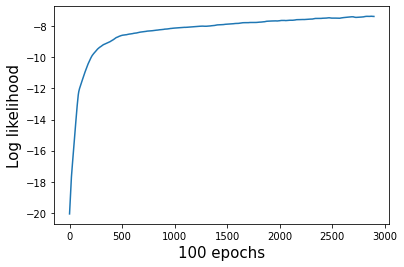

In [19]:
# Smooth and plot the loss 
M = 100
l_smooth = []

for i in range(0, len(training_log_likelihood) - M):
    l_smooth.append(np.mean(training_log_likelihood[i:i+M]))

plt.plot(l_smooth)
plt.xlabel(f'{M} epochs', fontsize=15)
plt.ylabel(f'Log likelihood', fontsize=15)
plt.savefig('training_log_likelihood.png')

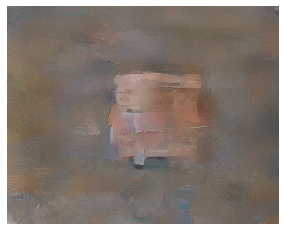

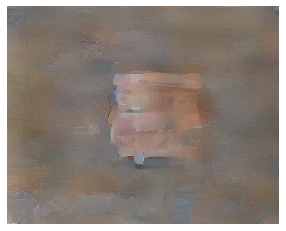

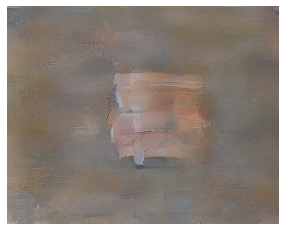

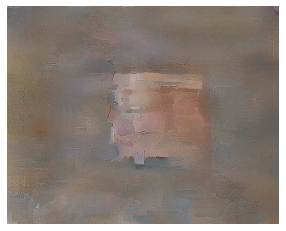

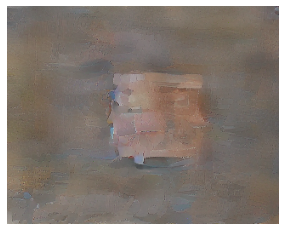

In [16]:
# Show the last 5 produced images 

for i in range(5):
    x_samples = model.decode_first_stage(torch.from_numpy(produced_images[-1 - i]).cuda())
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

    plt.imshow(x_samples[0].cpu().data.transpose(0, 1).transpose(1, 2).numpy())
    plt.savefig(f'after_{i}.png')
    plt.gca().axis('off')
    plt.show()

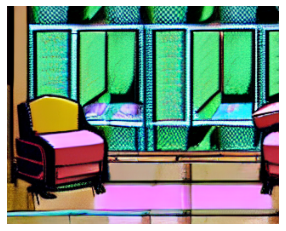

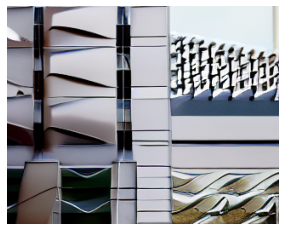

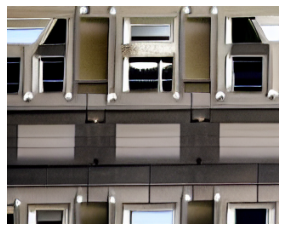

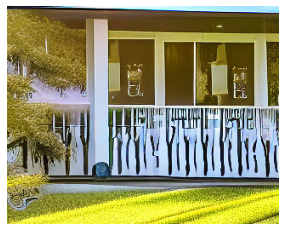

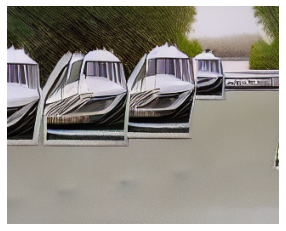

In [13]:
# Show the first 5 produced images 

for i in range(5):
    x_samples = model.decode_first_stage(torch.from_numpy(produced_images[i]).cuda())
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

    plt.imshow(x_samples[0].cpu().data.transpose(0, 1).transpose(1, 2).numpy())
    plt.savefig(f'before_{i}.png')
    plt.gca().axis('off')
    plt.show()